In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from src.utils import *
from tqdm import tqdm
from copy import deepcopy

ns=10
dataset = 'covid'
seed=0
n_synthetic = 1000


# Understand subgroup gain

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]),
 [Text(0, 0.0, '0.00'),
  Text(0, 0.01, '0.01'),
  Text(0, 0.02, '0.02'),
  Text(0, 0.03, '0.03'),
  Text(0, 0.04, '0.04'),
  Text(0, 0.05, '0.05'),
  Text(0, 0.06, '0.06'),
  Text(0, 0.07, '0.07')])

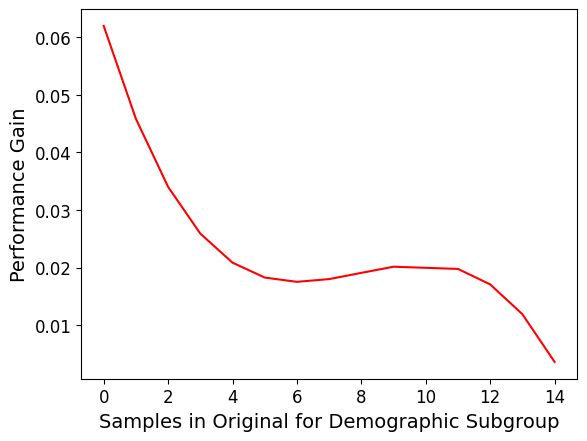

In [2]:
from scipy import stats
myscores = {}

demographic = ['Age_40', 'Age_40_50', 'Age_50_60', 'Age_60_70',
       'Age_70',  'Branca', 'Preta', 'Amarela',
       'Parda', 'Indigena']


gen_models = ['gpt4']

for gen_model in gen_models:

    xs = []
    ys = []


    for seed in range(0,10):
        try:
                ns=10

                #import from investigate_saves
                filename = f"./investigate_saves_all/investigate_{dataset}_{seed}_{ns}.pickle"

                with open(filename, 'rb') as handle:
                    investigate = pickle.load(handle)


                subgroups_res_diff = investigate['subgroups_diff']
                X_train_orig = investigate['X_train_orig']

                
                nf=50
                if gen_model == 'gpt4':
                    top_5_keys = [k for k, v in sorted(subgroups_res_diff[gen_model].items(), key=lambda item: item[1], reverse=True)[:nf]]


                sorted_dict = dict(sorted(subgroups_res_diff[gen_model].items(), key=lambda item: item[1], reverse=True))
                for key in top_5_keys:

                    if key not in demographic:
                        continue

                    if key=='Indigena':
                        continue

                    X_test_group = X_train_orig[X_train_orig[key]==1]

                    xs.append(X_test_group.shape[0])
                    ys.append(sorted_dict[key])

        
        except Exception as e:
            print(e)
            import traceback
            print(traceback.format_exc())
            continue

    myscores[gen_model] = {'xs': xs, 'ys': ys}



for idx, key in enumerate(gen_models):
    xs = np.array(myscores[key]['xs'])
    ys = np.array(myscores[key]['ys'])

    colors = plt.cm.plasma(np.linspace(0,1,len(gen_models)))
    color = colors[idx]

    if idx==1:
        color = 'r'
 
    import operator
    sort_axis = operator.itemgetter(0)

    xs_new = []
    ys_mean = []
    ys_new = []
    for x in np.unique(xs):
        idx = np.where(xs==x)[0]
        y_all = ys[idx]
        # z-score filter for outliers runs (just to reduce jitter)
        z = np.abs(stats.zscore(y_all))
        idx = np.where(z < 1)[0]
        if len(y_all[idx])>0:
            yz = y_all[idx]
        else:
            yz = y_all

        y_mean = np.mean(yz)
        xs_new.append(x)
        ys_mean.append(y_mean)
    
    xs = np.array(xs_new)
    ymean = np.array(ys_mean)


    k=3
    # polynomial fit to show a trend  of the relationship
    sorted_zip = sorted(zip(xs,ymean), key=sort_axis)
    xs, ys = zip(*sorted_zip)
    z = np.polyfit(xs, ys, k)
    p = np.poly1d(z)
    plt.plot(xs,p(xs), color='r')


fs = 14
plt.xlabel('Samples in Original for Demographic Subgroup', fontsize=fs)
plt.ylabel('Performance Gain', fontsize=fs) 

plt.xticks(fontsize=fs-2)
plt.yticks(fontsize=fs-2)
   

# Subgroup gain deep-dive (GPT4 vs TVAE)

In [3]:
from scipy import stats
from scipy.stats import sem

total_compare_dict = {}
total_samples_dict = {}
total_gen_dict = {}

nf = 5
seeds=10

for seed in range(seeds):  # From seed=0 to seed=10

  
    model = 'gpt4'

    # Import from investigate_saves
    filename = f"./investigate_saves_all/investigate_{dataset}_{seed}_{ns}.pickle"

    with open(filename, 'rb') as handle:
        investigate = pickle.load(handle)


    X_train_orig = investigate['X_train_orig']
    X_syn = investigate['results'][model]['df']

    subgroups_res_diff = investigate['subgroups_diff']
    dict1 = subgroups_res_diff['gpt4_LD']
    dict2 = subgroups_res_diff['gpt4']

    compare_dict = subgroups_res_diff[model] #{key: dict1[key] - dict2[key] for key in dict1}

    # Accumulate results
    for key, value in compare_dict.items():
        # add to a list

        # if key not in compare_dict: create a list
        # else: append to the list

        if key not in total_compare_dict:
            total_compare_dict[key] = [value]
        else:

            tmp_dict = total_compare_dict[key]
            tmp_dict.append(value)
            total_compare_dict[key] = tmp_dict

        if key not in total_samples_dict:
            total_samples_dict[key] = [X_train_orig[X_train_orig[key]==1].shape[0]]
        else:

            tmp_dict = total_samples_dict[key]
            tmp_dict.append(X_train_orig[X_train_orig[key]==1].shape[0])
            total_samples_dict[key] = tmp_dict

        if key not in total_gen_dict:
            total_gen_dict[key] = [X_syn[X_syn[key]==1].shape[0]]
        else:

            tmp_dict = total_gen_dict[key]
            tmp_dict.append(X_syn[X_syn[key]==1].shape[0])
            total_gen_dict[key] = tmp_dict



for key in total_compare_dict.keys():

    tmp_list = np.array(total_compare_dict[key])
    z = np.abs(stats.zscore(tmp_list))
    threshold = 2
    idx = np.where(z < threshold)[0]
    if len(tmp_list[idx])>0:
        new_list = tmp_list[idx]
    else:
        new_list = tmp_list
    
    total_compare_dict[key] = new_list



# Calculate average
average_compare_dict = {key: f"{np.round(np.mean(total_compare_dict[key])*100,2)}+-{np.round(sem(total_compare_dict[key])*100,2)}" for key in total_compare_dict}

top_5_keys = [k for k, v in sorted(average_compare_dict.items(), key=lambda item: item[1], reverse=True)[:nf]]

# Assuming the `gpt_df` remains the same for all seeds, only doing this once:
gpt_df = investigate['results'][model]['X']

print('GPT4 - Deep Dive')
print(f"Subgroup & Gain & Min-Max Samples \\\\ \\hline")
for key in average_compare_dict:
    if key not in top_5_keys:
        continue
    X_test_group = gpt_df[gpt_df[key] == 1]
    X_test_group = X_train_orig[X_train_orig[key]==1]
    samples = total_samples_dict[key]
    samples_gen = total_gen_dict[key]
    print(f"{key} & {average_compare_dict[key]} & {np.min(samples)}-{np.max(samples)} ({np.min(samples_gen)}-{np.max(samples_gen)}) \\\\")



 

GPT4 - Deep Dive
Subgroup & Gain & Min-Max Samples \\ \hline
Age_40 & 6.38+-2.09 & 0-6 (42-220) \\
Liver & 3.85+-3.37 & 0-1 (56-120) \\
Renal & 4.52+-2.01 & 0-3 (135-257) \\
Amarela & 8.71+-1.4 & 0-1 (93-177) \\
Parda & 5.07+-1.5 & 3-11 (212-404) \\


In [4]:

total_compare_dict = {}
total_samples_dict = {}
total_gen_dict = {}

nf = 5
seeds=10

for seed in range(seeds):  # From seed=0 to seed=10

  
    model = 'tvae'

    # Import from investigate_saves
    filename = f"./investigate_saves_all/investigate_{dataset}_{seed}_{ns}.pickle"

    with open(filename, 'rb') as handle:
        investigate = pickle.load(handle)


    X_train_orig = investigate['X_train_orig']
    X_syn = investigate['results'][model]['df']

    subgroups_res_diff = investigate['subgroups_diff']
    dict1 = subgroups_res_diff['gpt4_LD']
    dict2 = subgroups_res_diff['gpt4']

    compare_dict = subgroups_res_diff[model] #{key: dict1[key] - dict2[key] for key in dict1}

    # Accumulate results
    for key, value in compare_dict.items():

        if key not in total_compare_dict:
            total_compare_dict[key] = [value]
        else:

            tmp_dict = total_compare_dict[key]
            tmp_dict.append(value)
            total_compare_dict[key] = tmp_dict

        if key not in total_samples_dict:
            total_samples_dict[key] = [X_train_orig[X_train_orig[key]==1].shape[0]]
        else:

            tmp_dict = total_samples_dict[key]
            tmp_dict.append(X_train_orig[X_train_orig[key]==1].shape[0])
            total_samples_dict[key] = tmp_dict

        if key not in total_gen_dict:
            total_gen_dict[key] = [X_syn[X_syn[key]==1].shape[0]]
        else:

            tmp_dict = total_gen_dict[key]
            tmp_dict.append(X_syn[X_syn[key]==1].shape[0])
            total_gen_dict[key] = tmp_dict



for key in total_compare_dict.keys():

    tmp_list = np.array(total_compare_dict[key])
    z = np.abs(stats.zscore(tmp_list))
    threshold = 2
    idx = np.where(z < threshold)[0]
    if len(tmp_list[idx])>0:
        new_list = tmp_list[idx]
    else:
        new_list = tmp_list
    
    total_compare_dict[key] = new_list


# Calculate average
average_compare_dict = {key: f"{np.round(np.mean(total_compare_dict[key])*100,2)}+-{np.round(sem(total_compare_dict[key])*100,2)}" for key in total_compare_dict}

# Assuming the `gpt_df` remains the same for all seeds, only doing this once:
gpt_df = investigate['results'][model]['X']

print('TVAE - Deep Dive')
print(f"Subgroup & Gain & Min-Max Samples \\\\ \\hline")
for key in average_compare_dict:
    if key not in top_5_keys:
        continue
    X_test_group = gpt_df[gpt_df[key] == 1]
    X_test_group = X_train_orig[X_train_orig[key]==1]
    samples = total_samples_dict[key]
    samples_gen = total_gen_dict[key]
    print(f"{key} & {average_compare_dict[key]} & {np.min(samples)}-{np.max(samples)} & {np.min(samples_gen)}-{np.max(samples_gen)} \\\\")

 

TVAE - Deep Dive
Subgroup & Gain & Min-Max Samples \\ \hline
Age_40 & -3.37+-2.86 & 0-6 & 0-394 \\
Liver & -13.1+-3.38 & 0-1 & 0-143 \\
Renal & -18.0+-3.22 & 0-3 & 0-126 \\
Amarela & -2.03+-2.88 & 0-1 & 0-40 \\
Parda & -6.57+-1.61 & 3-11 & 28-809 \\
